# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
def map_component_to_features(pca, component, column_names):
    """
    Returns weights of features for a selected component.
    
    Input:
    pca - fitted PCA object
    component - PCA component of interest
    column_names - list of original feature names
    
    Output:
    df_features - sorted DataFrame with feature weigths
    """
    
    weights_array = pca.components_[component]
    df_features = pd.DataFrame(weights_array, index = column_names, columns=['weight'])
    return df_features.sort_values(by='weight', ascending=False).round(2)

In [3]:
def draw_learning_curves(X, y, estimator, num_trainings):
    """
    Draw learning curve that shows the validation and training auc_score of an estimator 
    for varying numbers of training samples.
    
    Input:
        X: array like sample
        y: array like target relative to X2 sample
        estimator: object type that implements the “fit” and “predict” methods
        num_trainings (int): number of training samples to plot
        
    Output:
        None
    """
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("AUC train score = {}".format(train_scores_mean[-1].round(2)))
    print("AUC validation score = {}".format(test_scores_mean[-1].round(2)))
    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("% of training set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()

In [4]:
def randomize(df):
    """
    Returns randomized dataframes/series X and y.
    
    Input: df DataFrame
    Output: randomized dataframes/series X and y
    """
    
    df_randomized = df.sample(frac=1)
    y_rand = df_randomized['RESPONSE']
    X_rand = df_randomized.drop(['RESPONSE'],axis=1)
    return X_rand, y_rand

In [5]:
def convert_keys_to_nan(df, keys_dict):
    """
    Replaces given keys from keys_dict to np.nan in df inplace
    
    Input:
        df (DataFrame): Dataset for which keys to np.nan need to be converted
        keys_dict: dictionary of attributes with keys that needs to be converted to np.nan
        
    Output:
        None
    """
    for attribute in keys_dict:
        
        # Check if attribute is in dataframe
        if attribute in df.columns:       
            keys_array = keys_dict[attribute]
            for key in keys_array:
                if key == 'X' or key == 'XX':
                    key = str(key)
                else:
                    key = int(key)
                
                df[attribute].replace(key, np.NaN, inplace=True)

In [6]:
def clean_dataframe(df, drop_cols, test_df=False):
    """
    Returns cleaned dataframe.
    
    Input: 
    df - Dataframe to be cleaned
    drop_cols - Columns of df to be dropped
    test_df - True if dataframe is mailout_test dataframe
    
    Output:
    df_clean - cleaned dataframe
    """
    
    # drop columns
    df_clean = df.drop(drop_cols, axis=1)
    
    # Convert columns 'EINGEFUEGT_AM' and 'OST_WEST_KZ'
    #df_clean = pd.concat([df_clean.drop(['CAMEO_DEU_2015'], axis=1), pd.get_dummies(df_clean['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015', drop_first=True, dummy_na=True)], axis=1)
    df_clean['EINGEFUEGT_AM'] = pd.to_datetime(df_clean['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
    df_clean['OST_WEST_KZ'].replace('O', 0, inplace=True)
    df_clean['OST_WEST_KZ'].replace('W', 1, inplace=True)
    df_clean['OST_WEST_KZ'] = pd.to_numeric(df_clean['OST_WEST_KZ'], errors = 'coerce')
    
    # Drop rows with more than 16 missing values if not mailout_test dataframe
    if test_df==False:
        rows_dropped = sum(df_clean.isnull().sum(axis=1) > 16)
        df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 16]
    else:
        rows_dropped = 0
    
    # Print new shape and datatypes
    print("Old shape: {}".format(df.shape))
    print("{} rows and {} columns dropped.".format(rows_dropped, len(drop_cols)))
    print("New shape: {} \n".format(df_clean.shape))
    print("Datatypes:")
    print(df_clean.get_dtype_counts())
    
    return df_clean    

In [7]:
def pca_scree_plot(pca):
    """
    Plots PCA scree plot.
    
    Input: pca - fitted PCA object
    Output: scree plot
    """
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)

    fig = plt.figure(figsize=(16,6))
    ax = plt.subplot()
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Cumulative explained variance ratio plot')
    
    return fig

In [8]:
def get_clusters_attributes(cluster_pipeline, numerical_cols, skewed_cols, column_names):
    """
    Function transforms clusters centers, by performin pca inverse transform,
    reverse scale for numerical(num_attributes) and atrributes with logarithmic transformation (log_attributes),
    and exponential transformation for log_attributes
    
    Input:
        cluster_pipeline: object of cluster_pipeline
        num_attributes: list of numerical attributes which were rescaled
        log_attributes: list of attributes wich had logarithmic transformation and also were rescaled
        column_names: names of all columns after Column Transformer operation
        
        
    Output:
        cluster_centers_df (DataFrame): DataFrame of cluster_centers with their attributes values
        
    """

    pca_components = cluster_pipeline.named_steps['reduce']
    kmeans = cluster_pipeline.named_steps['cluster']
    transformer =  cluster_pipeline.named_steps['transform']

    cluster_centers = pca_components.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=column_names)

    num_scale = transformer.named_transformers_['numerical'].named_steps['num_scale']
    log_scale = transformer.named_transformers_['skewed'].named_steps['log_scale']
    log_transform = transformer.named_transformers_['skewed'].named_steps['log_transform']

    cluster_centers_df[numerical_cols] = num_scale.inverse_transform(cluster_centers_df[numerical_cols])
    cluster_centers_df[skewed_cols] = log_scale.inverse_transform(cluster_centers_df[skewed_cols])
    cluster_centers_df[skewed_cols] = log_transform.inverse_transform(cluster_centers_df[skewed_cols])

    return cluster_centers_df  

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

#### Load data

In [9]:
# Load data
#azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
#customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [10]:
# pickle dataframes to speed-up data loading next time
#azdias.to_pickle('azdias.pickle')
#customers.to_pickle('customers.pickle')

In [11]:
# load pickled data
azdias = pd.read_pickle('azdias.pickle')
customers = pd.read_pickle('customers.pickle')

### Data Exploration & Visualization

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood.

#### Shape of datasets

In [12]:
# Shape of general population dataset
print("Shape of general population dataset: {} rows, {} columns".format(azdias.shape[0], azdias.shape[1]))
azdias.head()

Shape of general population dataset: 891221 rows, 366 columns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [13]:
# Shape of customers dataset
print("Shape of customers dataset: {} rows, {} columns".format(customers.shape[0], customers.shape[1]))
customers.head()

Shape of customers dataset: 191652 rows, 369 columns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [14]:
# Differences in columns
azdias_columns = set(azdias.columns)
customers_columns = set(customers.columns)
customers_columns - azdias_columns

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

The customers dataset has three columns more: 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'.

#### Data types

In [15]:
# Show dtypes and corrsp. number of columns
azdias.get_dtype_counts()

float64    267
int64       93
object       6
dtype: int64

In [16]:
# Print categorical columns
azdias.select_dtypes(['object']).head(5)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [17]:
customers.get_dtype_counts()

float64    267
int64       94
object       8
dtype: int64

In [18]:
customers.select_dtypes(['object']).head(5)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


Azdias dataset has 6 categorical columns of which one is a date column. Customers has two more columns which are not in the Azdias dataset.

The common categorical columns are:
* CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015: These describe the sociodemographic background of a household (cluster) based on the CAMEO classification system.
* D19_LETZTER_KAUF_BRANCHE: No description is provided for this column. However, based on the column name it could be referred to the industry of the latest purchase of the household (shoes, food, etc)
* EINGEFUEGT_AM: Again, no description provided but seems like the date when the household entry was added to the database.
* OST_WEST_KZ: Indicates if the building is located (was constructed?) in the former GDR/East Germany (O) or FDR/West Germany (W).

#### Descriptive statistics

In [19]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [20]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


#### Missing values

For some attributes a value denotes a missing information according to the "DIAS Attributes - Values 2017.xlsx". Firstly, the corresponding value(s) needs to be identified for each attribute. The respective value(s) can then be replaced by nans in each column.

In [21]:
# Load Excel and filter for missing value classes
attr_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str')
missing_keys = attr_values[attr_values["Meaning"].isin(["unknown","unknown / no main age detectable"])]

In [22]:
# Create dict of missing attribute-value combinations
missing_keys_dict = {}
for _, row in missing_keys.iterrows():
    key = row["Attribute"]
    missing_keys_dict[key] = row["Value"].split(", ")

# Manually add missing codes from other/similar attributes 
missing_keys_dict["CAMEO_INTL_2015"] = ['XX']
missing_keys_dict["CAMEO_DEUG_2015"] = ['X','XX']
missing_keys_dict["CAMEO_DEU_2015"] =['XX']
missing_keys_dict["GEBURTSJAHR"] = ['0']
missing_keys_dict["CAMEO_INTL_2015"] == missing_keys_dict["CAMEO_DEUINTL_2015"]
missing_keys_dict["KBA13_CCM_1401_2500"] = missing_keys_dict["KBA13_CCM_1400_2500"]
missing_keys_dict["KBA13_BAUMAX"] = missing_keys_dict["KBA05_BAUMAX"]
missing_keys_dict["KBA13_ANTG1"] =  missing_keys_dict["KBA05_ANTG1"]
missing_keys_dict["KBA13_ANTG2"] =  missing_keys_dict["KBA05_ANTG2"]
missing_keys_dict["KBA13_ANTG3"] =  missing_keys_dict["KBA05_ANTG3"]
missing_keys_dict["KBA13_ANTG4"] =  missing_keys_dict["KBA05_ANTG4"]

In [23]:
convert_keys_to_nan(azdias, missing_keys_dict)

##### Missing columns

In [24]:
# Count and share of missing values
azdias_null = azdias.isnull().sum()
azdias_null_share = azdias_null/len(azdias) * 100

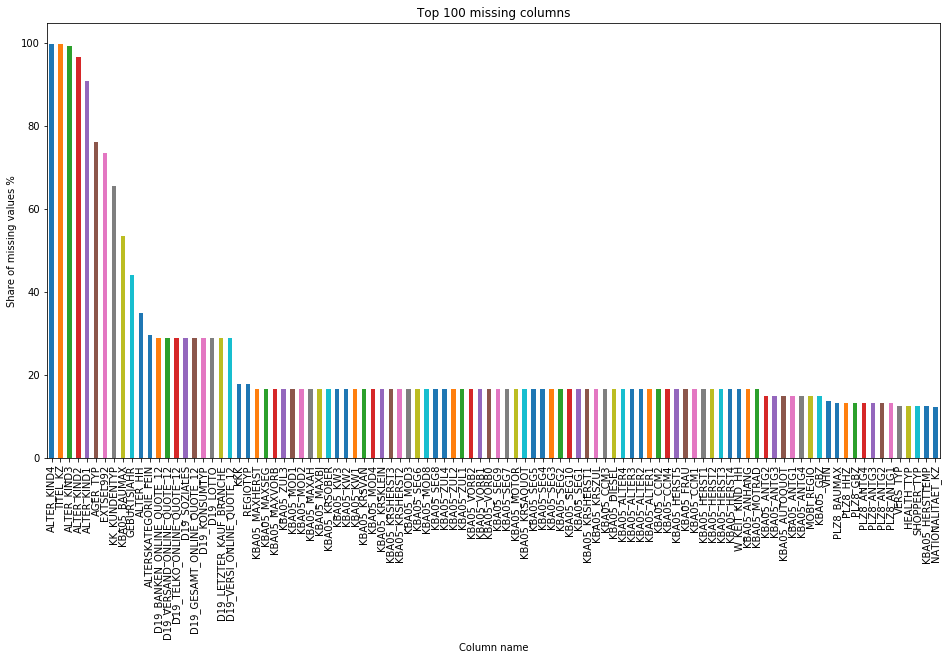

In [25]:
# Plot 100 columns with highest share of missing values
ax = azdias_null_share.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(16,8), title='Top 100 missing columns')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")
ax.figure.savefig('top_missing.png', dpi=500);

8 columns have 60% or more missing values. Most of the columns have less than 20% missing values.

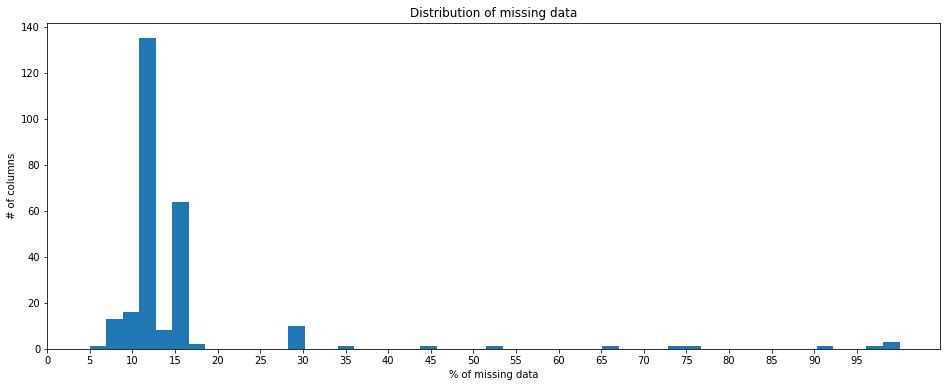

In [26]:
# Plot distribution of missing values
plt.figure(figsize=(16,6))
plt.hist(azdias_null_share, bins=np.linspace(5,100))

plt.xticks(np.arange(0, 100, 5))
plt.ylabel('# of columns')
plt.xlabel('% of missing data')
plt.title('Distribution of missing data')
plt.savefig('distribution_missing.png', dpi=500);

In [27]:
azdias_null_share.describe()

count    366.000000
mean      11.486055
std       13.829709
min        0.000000
25%        0.544646
50%       11.871354
75%       13.073637
max       99.864792
dtype: float64

In [28]:
print("On average, columns have a missing share of {}%.".format(round(azdias_null_share.mean(),1)))

On average, columns have a missing share of 11.5%.


In [29]:
print("97% of columns have a missing share of {}% or less.".format(round(azdias_null_share.quantile(0.97),1)))

97% of columns have a missing share of 29.8% or less.


In [30]:
drop_null_cols = list(azdias_null_share[azdias_null_share>30].index)
print("{} columns that have more than 30% missing values will be dropped: {}".format(len(drop_null_cols),drop_null_cols))

11 columns that have more than 30% missing values will be dropped: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


##### Other columns to drop

In [31]:
cat_columns = azdias.select_dtypes(['object']).columns

In [32]:
for col in cat_columns:
    print("Column {}: {} unique values".format(col, azdias[col].nunique()))

Column CAMEO_DEU_2015: 44 unique values
Column CAMEO_DEUG_2015: 9 unique values
Column CAMEO_INTL_2015: 21 unique values
Column D19_LETZTER_KAUF_BRANCHE: 35 unique values
Column EINGEFUEGT_AM: 5162 unique values
Column OST_WEST_KZ: 2 unique values


* 'CAMEO_DEU_2015' has many unique values but will be kept as it might be a powerful feature. 
* 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015' will be dropped as they are similar attributes to 'CAMEO_DEU_2015'.
* 'D19_LETZTER_KAUF_BRANCHE' will be dropped due to many unique values.
* 'EINGEFUEGT_AM' will be transformed to datetime year.
* 'OST_WEST_KZ' will be converted to 0/1 with 0 = OST and 1 = WEST

'LNR' is the unique identifier of each person and will be dropped as well.

In [33]:
# append to drop cols
drop_cols = drop_null_cols + ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'LNR']
print("{} columns will be dropped from the dataset: {}".format(len(drop_cols), drop_cols))

15 columns will be dropped from the dataset: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'LNR']


##### Missing rows

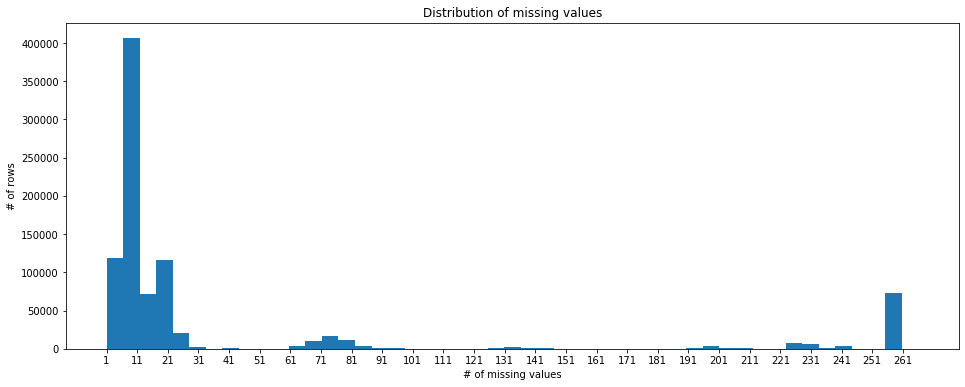

In [34]:
# Plot distribution of missing values
x = azdias.isnull().sum(axis=1)
plt.figure(figsize=(16,6))
plt.hist(x, bins=np.linspace(min(x), max(x)+1))

plt.xticks(np.arange(min(x), max(x)+1, 10))
plt.ylabel('# of rows')
plt.xlabel('# of missing values')
plt.title('Distribution of missing values');

In [35]:
azdias_null_rows = azdias.isnull().sum(axis=1)

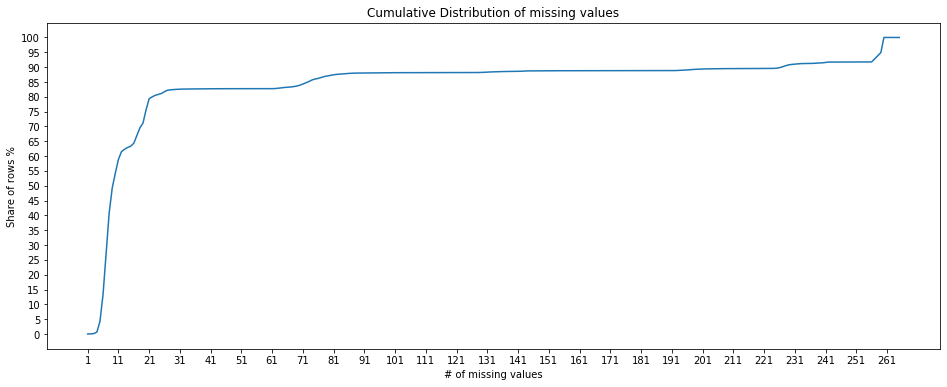

In [36]:
x = (azdias_null_rows.value_counts().sort_index().cumsum()/len(azdias)) * 100
plt.figure(figsize=(16,6))
plt.plot(x)

plt.yticks(np.arange(0, 100+5, 5))
plt.xticks(np.arange(min(x.index), max(x.index)+1, 10))
plt.ylabel('Share of rows %')
plt.xlabel('# of missing values')
plt.title('Cumulative Distribution of missing values')
plt.savefig('dist_missing_rows.png', dpi=500);

In [37]:
azdias_null_rows.describe()

count    891221.000000
mean         42.038960
std          76.354371
min           1.000000
25%           7.000000
50%          10.000000
75%          20.000000
max         265.000000
dtype: float64

In [38]:
x[15:30]

16    64.306721
17    66.954437
18    69.518559
19    71.136228
20    75.611885
21    79.330267
22    79.977806
23    80.487668
24    80.799712
25    81.115458
26    81.729896
27    82.211258
28    82.347813
29    82.437577
30    82.505237
dtype: float64

~82% of rows have 16 or less missing values. Dropping all rows with more than 16 missing values results in a loss of 18% of rows. This is were the line is drawn.

### Clean data

In [39]:
azdias_clean = clean_dataframe(azdias, drop_cols)

Old shape: (891221, 366)
159296 rows and 15 columns dropped.
New shape: (731925, 351) 

Datatypes:
float64    265
int64       85
object       1
dtype: int64


In [40]:
customers_clean = clean_dataframe(customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1), drop_cols)

Old shape: (191652, 366)
59550 rows and 15 columns dropped.
New shape: (132102, 351) 

Datatypes:
float64    260
int64       90
object       1
dtype: int64


### Impute, transform, and standardize features

#### Classify attribute types and build pipelines

Imputation should be based on the type of attribute:
* **Skewed continuous:** There are (at least) 7 attributes in the dataset that are continuous numbers, like number of people in household. In contrast most other numerical values are discrete and denote a specific classification. Continuous numbers that show highly skewed distribution should be log-transformed first before imputation. Missing values are then median imputed after transformation.
* **Binary:** Some attributes only take 2 (non-missing) values. Missing values should be imputed based on the most common value.
* **Categorical:** These will be one-hot encoded first and then imputed like binary attributes (most common value).
* **Numerical:** Missing values of numerical attributes will be imputed based on the median value.

##### Skewed continuous

In [41]:
continuous_cols = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']

In [42]:
skewed_cols = []
for col in continuous_cols:
    try:
        skewness = skew(azdias_clean[col].dropna())
        print("{}, Skewness: {}".format(col, round(skewness,1)))
        if abs(skewness) > 1:
                        skewed_cols.append(col)
    except:
         pass

ANZ_HAUSHALTE_AKTIV, Skewness: 8.7
ANZ_HH_TITEL, Skewness: 22.4
ANZ_PERSONEN, Skewness: 1.8
ANZ_TITEL, Skewness: 18.1
KBA13_ANZAHL_PKW, Skewness: 1.3
MIN_GEBAEUDEJAHR, Skewness: 3.1


In [43]:
skewed_cols

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

In [44]:
# Transform-impute Pipeline
skew_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log_scale', StandardScaler())
])

##### Binary

In [45]:
num_cols = azdias_clean.select_dtypes(['float64', 'int64']).columns

In [46]:
binary_cols = []
for col in num_cols:
    n_unique = azdias_clean[col].dropna().nunique()
    if n_unique == 2:
        binary_cols.append(col)

In [47]:
binary_cols

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KBA05_SEG6',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ANREDE_KZ']

In [48]:
# Transform-impute Pipeline
binary_pipeline = Pipeline([('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

##### Categorical

In [49]:
categorical_cols = list(azdias_clean.select_dtypes(['object']).columns)
categorical_cols

['CAMEO_DEU_2015']

In [50]:
categorical_pipeline = Pipeline([
    ('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

##### Numerical

In [51]:
numerical_cols = list(set(azdias_clean.columns) - set(skewed_cols) - set(binary_cols) - set(categorical_cols))

In [52]:
# Transform-impute Pipeline
numerical_pipeline = Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
])

#### Combine pipelines

In [53]:
transformers = [('skewed', skew_pipeline, skewed_cols),
               ('binary', binary_pipeline, binary_cols),
               ('categorical', categorical_pipeline, categorical_cols),
               ('numerical', numerical_pipeline, numerical_cols)]

In [54]:
column_transformer = ColumnTransformer(transformers = transformers)

#### Transform features

In [55]:
azdias_trans = column_transformer.fit_transform(azdias_clean)

In [56]:
# Get column names from one hot encoded features
dummy_cols = list(column_transformer.transformers_[2][1].named_steps['onehot'].get_feature_names(categorical_cols))

In [57]:
# Create list of column names for transformed dataframe
column_names = skewed_cols + binary_cols + dummy_cols + numerical_cols

In [58]:
# Create transformed dataframe
azdias_trans = pd.DataFrame(azdias_trans, columns=[column_names])

In [59]:
# Check if all features are numerical
azdias_trans.get_dtype_counts()

float64    394
dtype: int64

## Part 1: Customer Segmentation Report

### Principal Component Analysis

The cleaned and transformed Azdias dataset has 394 different features. The feature range can be reduced by applying PCA. 

In [57]:
# Fit PCA object
pca = PCA().fit(azdias_trans)

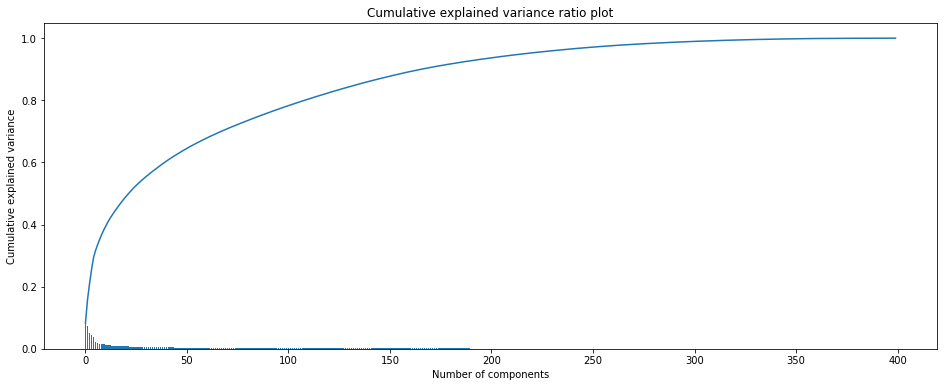

In [61]:
# Plot scree plot
fig = pca_scree_plot(pca)
fig.savefig('scree_plot.png', dpi=500)

In [154]:
cum_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'])
cum_variance.set_index(cum_variance.index+1, inplace=True)

In [155]:
num_components = cum_variance[cum_variance['cumulative_variance']>.95].index[0]
print('{} components explain 95% of variance in the dataset.'.format(num_components))

220 components explain 95% of variance in the dataset.


Of the close to 400 features in the dataset there are **220** that explain 95% of the variance. The dataset can be reduced to almost half of its feature range while only losing 5% of variance.

In [60]:
pca = PCA(n_components=220).fit(azdias_trans)
azdias_reduced = pd.DataFrame(pca.transform(azdias_trans))

In [61]:
top_three_pca = pca.explained_variance_ratio_[:3]

In [62]:
print("The first three components explain {:.1%} of variance.".format(top_three_pca.sum()))

The first three components explain 19.0% of variance.


In [63]:
print("Component 1 explains {:.1%} of variance and is determined by: ".format(top_three_pca[0]))
map_component_to_features(pca, 0, azdias_trans.columns).head()

Component 1 explains 8.6% of variance and is determined by: 


,weight
MOBI_REGIO,0.14
PLZ8_ANTG1,0.13
KBA13_ANTG1,0.13
LP_STATUS_FEIN,0.13
KBA05_ANTG1,0.13


In [64]:
map_component_to_features(pca, 0, azdias_trans.columns).tail()

,weight
PLZ8_ANTG4,-0.12
KBA13_ANTG4,-0.12
KBA13_ANTG3,-0.13
PLZ8_ANTG3,-0.13
ANZ_HAUSHALTE_AKTIV,-0.13


Component 1 is mainly determined by the mobility and social status of the person.

In [161]:
print("Component 2 explains {:.1%} of variance and is determined by: ".format(top_three_pca[1]))
map_component_to_features(pca, 1, azdias_trans.columns).head()

Component 2 explains 5.3% of variance and is determined by: 


,weight
ONLINE_AFFINITAET,0.15
PRAEGENDE_JUGENDJAHRE,0.15
D19_GESAMT_ANZ_24,0.14
CJT_TYP_2,0.14
FINANZ_SPARER,0.14


In [162]:
map_component_to_features(pca, 1, azdias_trans.columns).tail()

,weight
D19_GESAMT_DATUM,-0.13
FINANZ_VORSORGER,-0.13
CJT_TYP_5,-0.13
D19_VERSAND_ONLINE_DATUM,-0.13
D19_GESAMT_ONLINE_DATUM,-0.14


Component 2 is determined by online affinity, a dominating movement in the person's youth, and the person's financial behaviour.

In [163]:
print("Component 3 explains {:.1%} of variance and is determined by: ".format(top_three_pca[2]))
map_component_to_features(pca, 2, azdias_trans.columns).head()

Component 3 explains 5.1% of variance and is determined by: 


,weight
KBA13_HERST_BMW_BENZ,0.18
KBA13_SEG_OBEREMITTELKLASSE,0.15
KBA13_MERCEDES,0.15
KBA13_BMW,0.15
KBA13_SITZE_4,0.14


In [164]:
map_component_to_features(pca, 2, azdias_trans.columns).tail()

,weight
KBA13_HALTER_25,-0.12
KBA13_KMH_180,-0.12
KBA13_KMH_140_210,-0.13
KBA13_SEG_KLEINWAGEN,-0.13
KBA13_SITZE_5,-0.15


Component 3 is determined by the car a person owns.

### K-means Clustering

The people in the general population dataset can be clustered by applying K-means clustering. Applying k-Means++ algorithm increases the efficiency. The final number of clusters is determined by using the elbow method.

In [65]:
sse = []
list_k = list(range(1, 31))

for k in list_k:
    km = KMeans(n_clusters=k, init='k-means++')
    km.fit(azdias_reduced.sample(20000))
    sse.append(km.inertia_)

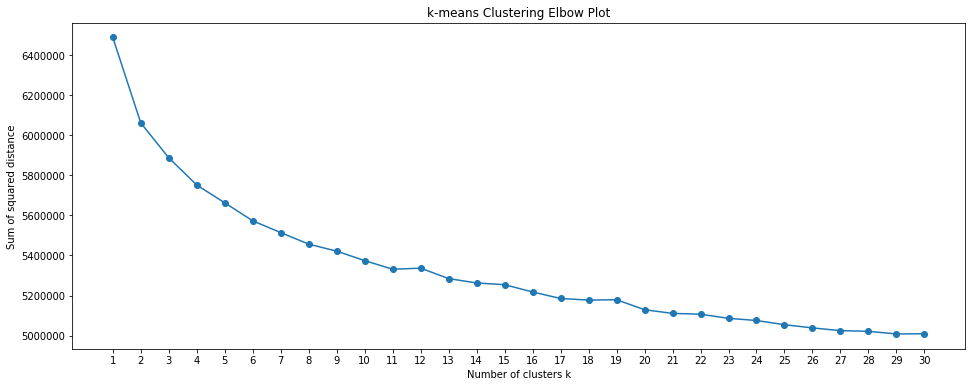

In [83]:
# Plot sse against k
plt.figure(figsize=(16, 6))
plt.plot(list_k, sse, '-o')
plt.title('k-means Clustering Elbow Plot')
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared distance")
plt.xticks(list(range(1,31)))
plt.savefig('elbow_plot.png', dpi=500);

There is no clear elbow in the plot. The inertia or sum of squared distances drops significantly until around 6 clusters and then basically flattens out with a few further drops at 14, 20, 23, ... clusters. At 13, inertia increases a bit so 12 clusters are chosen as final number.

### Transform, reduce and cluster cleaned customers dataset

In [67]:
# Set PCA and KMeans parameters
pca_components = 220
kmeans_clusters = 12

In [68]:
# Create cluster pipeline
cluster_pipeline = Pipeline([
    ('transform', column_transformer),
    ('reduce', PCA(n_components = pca_components)),
    ('cluster', KMeans(n_clusters = kmeans_clusters, init = 'k-means++'))
])

In [69]:
# Fit cluster pipeline and create clustered general population dataframe
cluster_pipeline.fit(azdias_clean)
azdias_clustered = pd.DataFrame(cluster_pipeline.predict(azdias_clean), columns = ['Cluster'])

In [70]:
# Create clustered customers dataframe
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customers_clean), columns = ['Cluster'])

In [71]:
azdias_clustered.to_pickle('azdias_clustered')
customers_clustered.to_pickle('customers_clustered')
#azdias_clustered = pd.read_pickle('azdias_clustered')
#customers_clustered = pd.read_pickle('customers_clustered')

In [72]:
# Get cluster sizes in each dataset
population_clusters = azdias_clustered['Cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

In [73]:
# Concat both dataframes to one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

In [74]:
# Calculate share of each cluster
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()*100
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()*100
clusters['diff_share'] = clusters['customers_share'] - clusters['population_share']

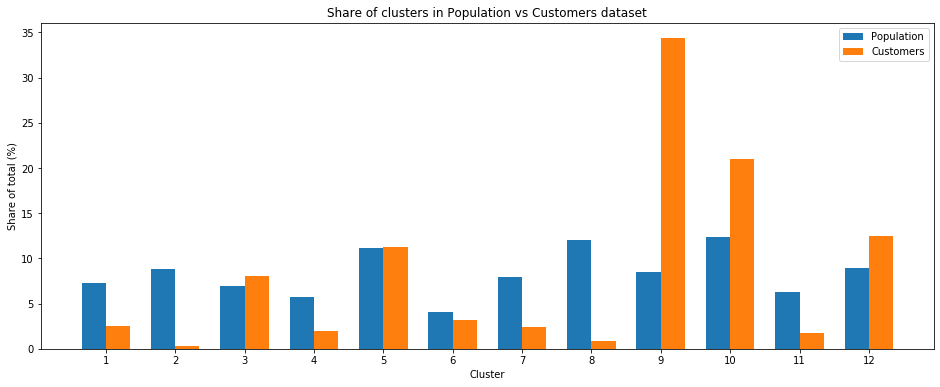

In [85]:
# Plot clusters 
fig, ax = plt.subplots(figsize=(16,6))

ind = np.arange(kmeans_clusters)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, clusters['population_share'], width, bottom=0)
p2 = ax.bar(ind + width, clusters['customers_share'], width, bottom=0)

ax.set_title('Share of clusters in Population vs Customers dataset')
ax.set_ylabel('Share of total (%)')
ax.set_xlabel('Cluster')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(clusters['cluster'])
ax.legend((p1[0], p2[0]), ('Population', 'Customers'))
ax.autoscale_view()

plt.savefig('clusters_1.png', dpi=500);

The plot shows how clusters are distributed across both datasets. Clusters are equally spread across the general population and show only small differences in size. This can be expected from dataset that represents the general population very well.

In contrast, the customers dataset exhibits a large imbalance across clusters. Cluster 9 and 10 stand out specifically: More than 50% of customers are mapped to these two clusters. The remaining share is distributed across clusters 5 and 12 while all other clusters only contain a small share of customers.  

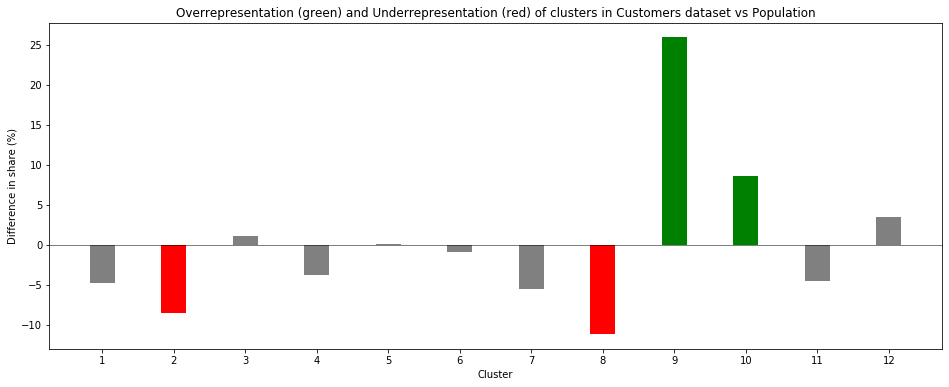

In [87]:
# Plot cluster differences
fig, ax = plt.subplots(figsize=(16,6))

ind = np.arange(kmeans_clusters)    # the x locations for the groups
width = 0.35         # the width of the bars

bar_colors = ('grey','red','grey','grey','grey','grey','grey','red','green','green','grey','grey')

p1 = ax.bar(ind, clusters['diff_share'], width, color = bar_colors)

ax.set_title('Overrepresentation (green) and Underrepresentation (red) of clusters in Customers dataset vs Population')
ax.set_ylabel('Difference in share (%)')
ax.set_xlabel('Cluster')

ax.axhline(linewidth=.5, color='black')

ax.set_xticks(ind)
ax.set_xticklabels(clusters['cluster'])

plt.savefig('clusters_2.png', dpi=500);

Clusters 9 and 10 are significantly overrepresented in the Customers dataset. These should be the focus of a marketing campaign for the firm. On the other hand, clusters 2 and 8 show the largest underrepresentation compared to the general population and are outside of the focus group. 

In [88]:
cluster_centers_df = get_clusters_attributes(cluster_pipeline, numerical_cols, skewed_cols, column_names)

In [89]:
comparison_df = cluster_centers_df.T[[8,9,1,7]]

In [90]:
comparison_df.columns=['interested_cluster_9','interested_cluster_10','not_interested_cluster_2','not_interested_cluster_8']

In [92]:
comparison_df[comparison_df.std(axis=1)>2]

,interested_cluster_9,interested_cluster_10,not_interested_cluster_2,not_interested_cluster_8
LP_LEBENSPHASE_GROB,8.004706,4.718162,2.525255,3.350580
EINGEZOGENAM_HH_JAHR,1999.979827,2000.728004,2005.356248,2005.628696
LP_LEBENSPHASE_FEIN,27.026184,16.490010,7.400173,10.764894
ANZ_STATISTISCHE_HAUSHALTE,2.360956,2.137019,12.066082,4.434107
D19_GESAMT_ONLINE_QUOTE_12,5.546279,0.627578,0.265035,0.747452
VK_ZG11,3.126616,5.810008,8.031530,7.756917
D19_KONSUMTYP_MAX,2.464837,6.535185,7.834241,7.223877
AKT_DAT_KL,2.063873,3.448639,6.885743,6.474712
D19_GESAMT_ONLINE_DATUM,5.139734,9.062734,9.458925,9.040411
D19_GESAMT_DATUM,4.082363,8.190865,9.078505,8.562975


Looking at attributes with the highest differences among the 4 focus clusters allows to define specific characteristics of the groups. 

Interested clusters:
* Are high-income couples or families.
* Live in more densily populated, probably more exclusive areas.
* Are used to buying things online.
* Are house owners and/or hold an academic title.
* Are 50-60 years old, grew up in the 60s/70s, and likely were part of the politically active generation 68/student protesters or Berlin wall opponents.

In contrast, not-interested clusters:
* Tend to be low- to average-income singles of advanced to higher age.
* Live in more crowded but rural areas.
* Rarely buy or order things online.
* Grew up in Eastern Germany in the 80s and likely participated in the communist party youth organisation.

In [146]:
comparison_df.loc['D19_SOZIALES']

interested_cluster_9        1.499231
interested_cluster_10       0.711209
not_interested_cluster_2    0.075782
not_interested_cluster_8    0.162990
Name: D19_SOZIALES, dtype: float64

In [82]:
comparison_df.to_pickle('comparison_df')
#comparison_df = pd.read_pickle('comparison_df')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [93]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [94]:
mailout_train.shape

(42962, 367)

In [96]:
mailout_train_clean = pd.concat([clean_dataframe(mailout_train.drop(['RESPONSE'], axis=1), drop_cols), mailout_train['RESPONSE']], axis=1)

Old shape: (42962, 366)
9327 rows and 15 columns dropped.
New shape: (33635, 351) 

Datatypes:
float64    260
int64       90
object       1
dtype: int64


In [97]:
X = mailout_train_clean.drop(['RESPONSE'], axis=1)
y = mailout_train_clean['RESPONSE']

In [98]:
models = {'RandomForestClassifier': RandomForestClassifier(), 
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': xgb.XGBClassifier()
         }

RandomForestClassifier
Roc_auc train score = 0.95
Roc_auc validation score = 0.58



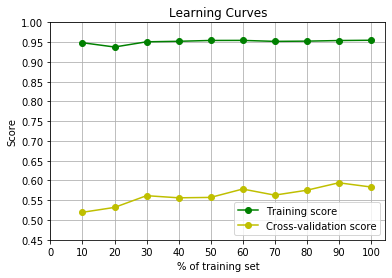

AdaBoostClassifier
Roc_auc train score = 0.83
Roc_auc validation score = 0.73



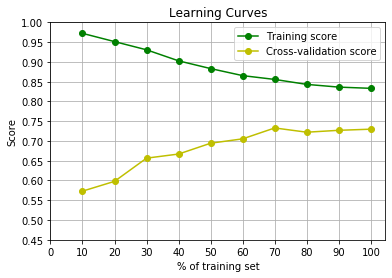

GradientBoostingClassifier
Roc_auc train score = 0.89
Roc_auc validation score = 0.75



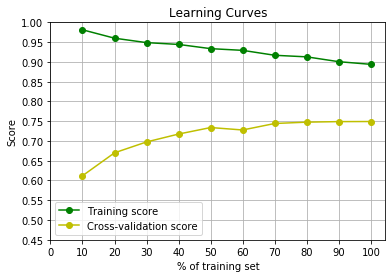

XGBClassifier
Roc_auc train score = 0.97
Roc_auc validation score = 0.66



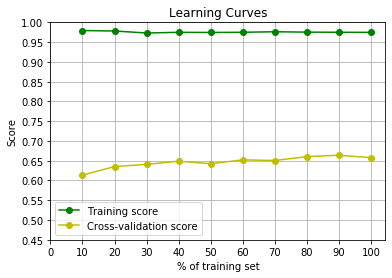

In [46]:
for model_key in models.keys():
    print(model_key)
    ml_pipeline = Pipeline([
        ('transform', column_transformer),
        ('model', models[model_key])
    ])
    X, y = randomize(mailout_train_clean)
    draw_learning_curves(X, y, ml_pipeline, 10)

The **Random Forest Classifier** does not only show the lowest mean validation score but also a consisently high train score, implying high model bias. In other words, the model is strongly overfitted on the training data and provides a bad predictor for unseen data. The same can be summarized for the **XGBoost Classifier**.

The **AdaBoost Classifier** and **Gradient Boosting Classifier** on the other hand show better performance. They demonstrate a decrease of model bias with increasing sample size. While AdaBoost curves already converged after ~80% of the sample is fed to the algorithm, learning curves for the Gradient Boosting Classifier keep converging with more data. In addition to that, Gradient Boosting provides the highest mean validation score, making it our choise of estimator for the forecasting model.

Finally, the parameters for the Gradient Boosting Classifiers are hypertuned using grid-search on the following selection:

In [99]:
#initialize with GradientBoostingClassifier
gbc_pipeline = Pipeline([
    ('transform', column_transformer),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

parameters = {'gbc__learning_rate': [0.1, 0.2], 'gbc__n_estimators': [100],
             'gbc__max_depth': [3, 5], 'gbc__min_samples_split': [2,4]}        
        
grid_obj = GridSearchCV(gbc_pipeline, parameters, scoring = 'roc_auc', verbose=50)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100, score=0.718, total= 1.6min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[CV] gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100, score=0.745, total= 1.6min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s
[CV] gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100, score=0.793, total= 1.6min
[Parallel(n_jobs=1)]: Done   3 out of  

[CV]  gbc__learning_rate=0.2, gbc__max_depth=3, gbc__min_samples_split=4, gbc__n_estimators=100, score=0.763, total= 1.6min
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 95.0min remaining:    0.0s
[CV] gbc__learning_rate=0.2, gbc__max_depth=3, gbc__min_samples_split=4, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.2, gbc__max_depth=3, gbc__min_samples_split=4, gbc__n_estimators=100, score=0.719, total= 1.6min
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 96.6min remaining:    0.0s
[CV] gbc__learning_rate=0.2, gbc__max_depth=3, gbc__min_samples_split=4, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.2, gbc__max_depth=3, gbc__min_samples_split=4, gbc__n_estimators=100, score=0.705, total= 1.7min
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 98.3min remaining:    0.0s
[CV] gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=2, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=2, gbc__n_estimators=100, sco

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('skewed',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('log_transform',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
      

In [101]:
# Get the estimator and predict
print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X)[:, 1]

# Make predictions using unoptimized and the best model
predictions = (gbc_pipeline.fit(X, y)).predict_proba(X)[:, 1]

print("ROC score: {:.4f}".format(roc_auc_score(y, predictions)))
print("Final ROC score: {:.4f}".format(roc_auc_score(y, best_predictions)))

{'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__min_samples_split': 4, 'gbc__n_estimators': 100}
ROC score: 0.8766
Final ROC: 0.8779


Using ROC as scoring metric, the model performance can be increased by 0.13 %-points by using the best classifier parameters vs default settings.

In [210]:
# Save to file in the current working directory
pkl_filename = "best_gradient_boosting.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(best_clf, file)

In [28]:
# Load best GBC model
with open("best_gradient_boosting.pkl", "rb") as input_file:
    best_clf = pickle.load(input_file)

In [211]:
best_clf.named_steps['gbc']

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Among the features that the classifier uses to predict customer response, D19_SOZIALES is by far the most important one. Unfortunately, the attribute is not described by the accompanying data guide.

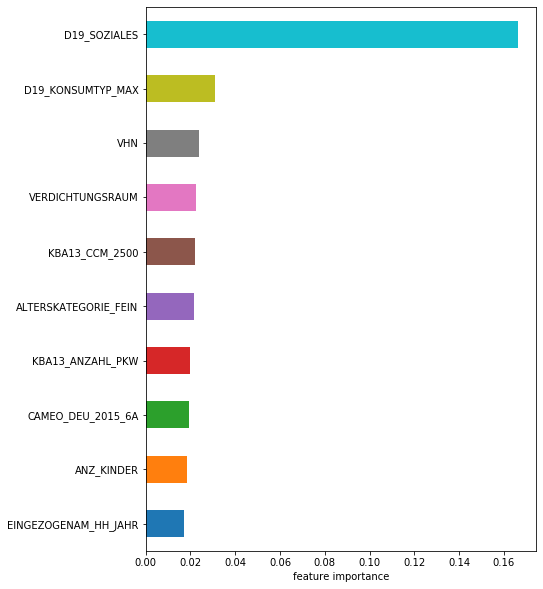

In [106]:
feature_importances = best_clf.named_steps['gbc'].feature_importances_
pd.Series(feature_importances, index=[''] + column_names).sort_values()[-10:].plot(kind='barh', figsize=(7,10))
plt.xlabel('feature importance')
plt.savefig('feature_importance.png', dpi=500);

Looking at the distribution of the D19_SOZIALES attribute in our focus clusters, we see a clear characteristic in these groups:

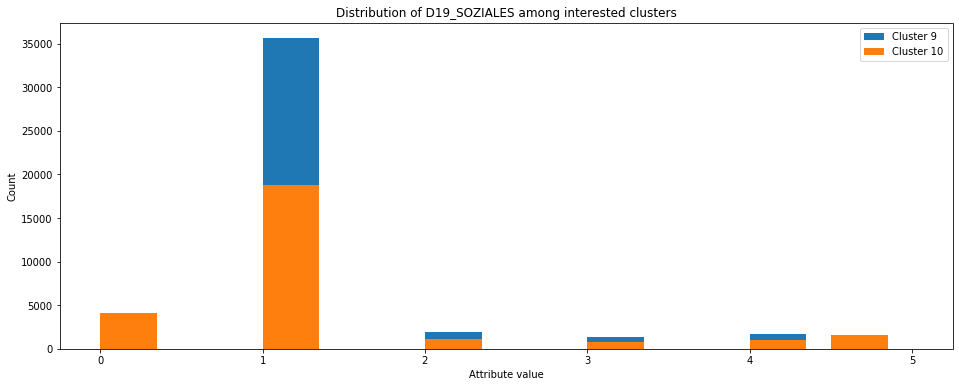

In [149]:
# Plot D19_SOZIALES distribution in relevant clusters
x1=customers_clean.iloc[customers_clustered[customers_clustered['Cluster'] == 8].index]['D19_SOZIALES']
x2=customers_clean.iloc[customers_clustered[customers_clustered['Cluster'] == 9].index]['D19_SOZIALES']


fig, ax = plt.subplots(figsize=(16,6))

width = 0.35 

p1 = plt.hist(x1, width=width, label='Cluster 9')
p2 = plt.hist(x2, width=width, label='Cluster 10')

plt.title('Distribution of D19_SOZIALES among interested clusters')
plt.ylabel('Count')
plt.xlabel('Attribute value')
plt.legend()
plt.savefig('d19_distribution.png', dpi=500);

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [214]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

In [215]:
mailout_test.shape

(42833, 366)

In [216]:
train_set= set(mailout_train.columns)
test_set= set(mailout_test.columns)

In [217]:
train_set - test_set

{'RESPONSE'}

In [218]:
mailout_test_clean = clean_dataframe(mailout_test, drop_cols, test_df = True)

Old shape: (42833, 366)
0 rows and 15 columns dropped.
New shape: (42833, 351) 

Datatypes:
float64    260
int64       90
object       1
dtype: int64


In [219]:
# Load from file
pkl_filename = "best_gradient_boosting.pkl"  
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file) 
    
#predict target values
kaggle_predict = pickle_model.predict_proba(mailout_test_clean)[:,1]

In [220]:
submission = pd.read_csv('Arvato_Capstone_Example_Submission.csv')
submission['RESPONSE'] = kaggle_predict
submission.to_csv('kaggle_submission.csv', index=False)

In a last step, the model performance is evaluated by predicting the response of each person in the "MAILOUT_TEST" dataset and submit the results to the Arvato Kaggle competition. The submission scored 0.75706, positioning it among the top 150.

### Conclusion

The Bertelsmann/Arvato Project proved to be a fun and engaging final exercise in the Data Science Nanodegree program. Handling the data was certainly among the biggest challenges in this project. Managing the high number of missing values and many different types of features can make a huge difference on final model performance.
Customers and general population were clustered into 12 groups, of which 2 showed to hold over 50% of the company's customers. These two focus groups had specific characteristics: Broadly speaking, customers of this company are well-earning couples or families with a certain affinity for online purchases.

To forecast customer responses, the Gradient Boosting Classifier proved to be the best-performing estimator. The Kaggle submission results shows that there is still room for improvement though. More specifically, the following changes to my approach could be considered to optimize project outcomes:
* Drop fewer or more data points when preparing the datasets.
* Test different approaches to standardize and scale features, like using Min-Max-Scaler instead of Standard Scaler.
* Choose a smaller number of clusters to group customers and population.
*Consider alternative classifiers than the ones described. Choose different parameters and ranges to hypertune the model.

The project is far from finished and leaves ample room for further exploration!